# FINM 250 Homework 4
### TA Solutions

## Part 3

### 1

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.append("../cmds")
from utils import (
    calc_univariate_regression,
    calc_iterative_regression,
    calc_performance_metrics
)


# Plotting settings.
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.family"] = "serif"
plt.style.use("ggplot")

# Pandas settings.
pd.set_option("display.float_format", lambda x: "{:.4f}".format(x))

ADJ = 12

from functools import partial

get_data = partial(
    pd.read_excel, "../data/gmo_analysis_data.xlsx", index_col=0, parse_dates=[0]
)

signals = get_data(sheet_name="signals")
returns = get_data(sheet_name="returns (total)")
spy = returns[['SPY']]
risk_free = get_data(sheet_name="risk-free rate")

In [2]:
signals_lag = signals.shift(1).dropna()
spy = spy.loc[signals_lag.index]

# Expanding.
forecast_df = spy.expanding().mean().shift(1).dropna()
forecast_df.columns = ['Mean']

# DP/EP regression.
dp_regr = sm.OLS(spy, sm.add_constant(signals_lag['DP'])).fit()
forecast_df['DP'] = dp_regr.params[0] + dp_regr.params[1] * signals['DP']
ep_regr = sm.OLS(spy, sm.add_constant(signals_lag['EP'])).fit()
forecast_df['EP'] = ep_regr.params[0] + ep_regr.params[1] * signals['EP']

print(f'DP Regression: Alpha: {dp_regr.params[0]:.4f}, Beta: {dp_regr.params[1]:.4f}, R^2: {dp_regr.rsquared:.4f}')
print(f'EP Regression: Alpha: {ep_regr.params[0]:.4f}, Beta: {ep_regr.params[1]:.4f}, R^2: {ep_regr.rsquared:.4f}')

# Multi-variate regression.
multi_regr = sm.OLS(spy, sm.add_constant(signals_lag)).fit()
forecast_df['Multi'] = multi_regr.params[0] + multi_regr.params[1] * signals['DP'] + multi_regr.params[2] * signals['EP'] + multi_regr.params[3] * signals['US10Y']

print('-'*50)
print('Multivariate Regression Summary')
display(multi_regr.params)
print(f'R^2: {multi_regr.rsquared:.4f}')

forecast_df.dropna(inplace=True)
forecast_df['Actuals'] = spy['SPY']
forecast_df['Risk-Free'] = risk_free['US3M']


DP Regression: Alpha: -0.0130, Beta: 0.0116, R^2: 0.0092
EP Regression: Alpha: -0.0034, Beta: 0.0026, R^2: 0.0051
--------------------------------------------------
Multivariate Regression Summary


const   -0.0145
DP       0.0092
EP       0.0021
US10Y   -0.0010
dtype: float64

R^2: 0.0141


### 2

In [3]:
forecast_wt = forecast_df * 100
forecast_model = forecast_wt[['DP', 'EP', 'Multi']]

forecast_model = forecast_model.multiply(forecast_df['Actuals'], axis=0)
forecast_model['Actuals'] = forecast_df['Actuals']

display(calc_performance_metrics(forecast_model).T)

# Calculate market stats.
calc_iterative_regression(forecast_model, forecast_model[['Actuals']], one_to_many=True).iloc[:-1, :]

,DP,EP,Multi,Actuals
Annualized Return,0.0691,0.0792,0.0756,0.0974
Annualized Volatility,0.1753,0.1258,0.1617,0.1558
Annualized Sharpe Ratio,0.3944,0.6293,0.4675,0.6253
Annualized Sortino Ratio,0.3806,0.8608,0.4872,0.8720
Skewness,-1.5453,-0.2234,-0.9188,-0.5507
Excess Kurtosis,14.7062,2.1192,7.3854,0.7749
VaR (0.05),-0.0626,-0.0591,-0.0728,-0.0789
CVaR (0.05),-0.1303,-0.0829,-0.1221,-0.0994
Min,-0.3529,-0.1233,-0.2717,-0.1652
Max,0.2398,0.1658,0.1980,0.1270


,Alpha,Beta,Downside Beta,R-Squared,Treynor Ratio,Information Ratio,Tracking Error
DP,-0.0216,0.9310,1.1526,0.6851,0.0742,-0.2195,0.0082
EP,0.0089,0.7210,0.5212,0.7976,0.1098,0.1576,0.0047
Multi,-0.0061,0.8388,0.6777,0.6531,0.0901,-0.0642,0.0079


### 3

,DP,EP,Multi,Actuals,Risk-Free
Annualized Return,0.0045,0.0274,0.0189,0.0182,0.0231
Annualized Volatility,0.2213,0.1272,0.1795,0.1628,0.0058
Annualized Sharpe Ratio,0.0203,0.2157,0.1055,0.1115,3.9866
Annualized Sortino Ratio,0.0200,0.3215,0.1059,0.1567,NaN
Skewness,-1.4120,0.3721,-1.0080,-0.3899,0.5194
Excess Kurtosis,11.3826,3.3346,7.7358,0.6061,-1.1040
VaR (0.05),-0.0821,-0.0578,-0.0954,-0.0813,0.0000
CVaR (0.05),-0.1772,-0.0786,-0.1424,-0.1018,0.0000
Min,-0.3529,-0.1092,-0.2717,-0.1652,0.0000
Max,0.2398,0.1658,0.1980,0.1091,0.0053


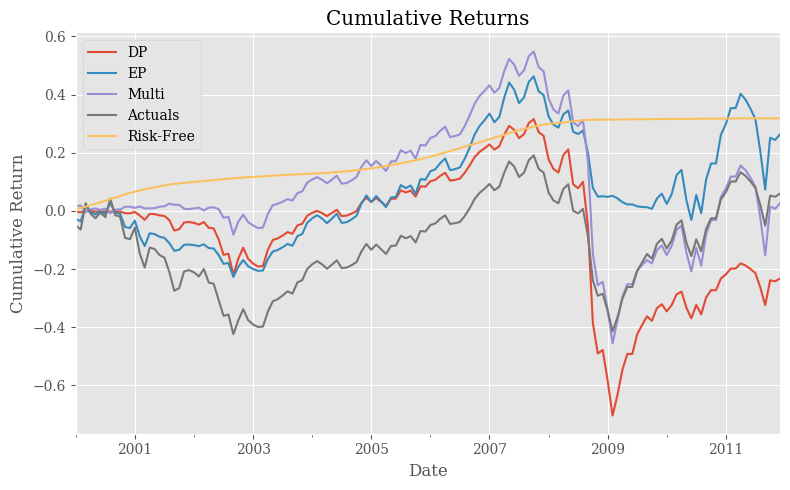

In [4]:
forecast_model['Risk-Free'] = forecast_df['Risk-Free']

forecast_subsample = forecast_model.loc['2000':'2011']
display(calc_performance_metrics(forecast_subsample).T)

fig, ax = plt.subplots(figsize=(8, 5))
forecast_subsample_cum = (forecast_subsample + 1).cumprod() - 1
forecast_subsample_cum.plot(ax=ax)

ax.set_title('Cumulative Returns')
ax.set_ylabel('Cumulative Return')
ax.set_xlabel('Date')
fig.tight_layout()

Short term bonds outperform all by the earnings-to-price ratio. However, the comparison is also a little unfair given that we are including the 2008 financial crisis, prior to 2008, all strategies except for SPY either outperform or are on par/slightly below the cumulative return of 3-month T-bills.

### 4

In [5]:
# Count negative forecasted returns.
neg_count = (forecast_df < 0).sum().to_frame('Count')
neg_count['Percentage'] = neg_count / len(forecast_df)
neg_count

,Count,Percentage
Mean,1,0.0031
DP,2,0.0063
EP,8,0.0252
Multi,40,0.1258
Actuals,115,0.3616
Risk-Free,0,0.0000


### 5

In [6]:
# Check risk metrics for GMWAX.
display(calc_performance_metrics(returns[['GMWAX']]).T)
display(calc_univariate_regression(returns['GMWAX'], returns['SPY']))

,GMWAX
Annualized Return,0.0476
Annualized Volatility,0.1123
Annualized Sharpe Ratio,0.4236
Annualized Sortino Ratio,0.5067
Skewness,-1.0474
Excess Kurtosis,3.3318
VaR (0.05),-0.0473
CVaR (0.05),-0.0833
Min,-0.1450
Max,0.0859


,Alpha,Beta,Downside Beta,R-Squared,Treynor Ratio,Information Ratio,Tracking Error
GMWAX,-0.0065,0.5481,0.3402,0.5793,0.0868,-0.0892,0.0061


For $r^X$; yes. Given that for all of the models we tested, they have very high market betas. So they are just loading up on market risk (by construction), so they do have a worse Sharpe Ratio, higher kurtosis, and worse risk metrics overall. I would say the EP performs the best out of all of them. 

Looking at GMWAX, I don't think it is necessarily risk that makes it worse, but rather it is just worse than SPY across the board, though it has a better max drawdown. Finally, it has a somewhat high market beta, at 0.55.

In [7]:
x = 1
y = pd.Series([1,2,3,4])

f'x={y[0:2]}'

'x=0    1\n1    2\ndtype: int64'